In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [4]:
import numpy as np
images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


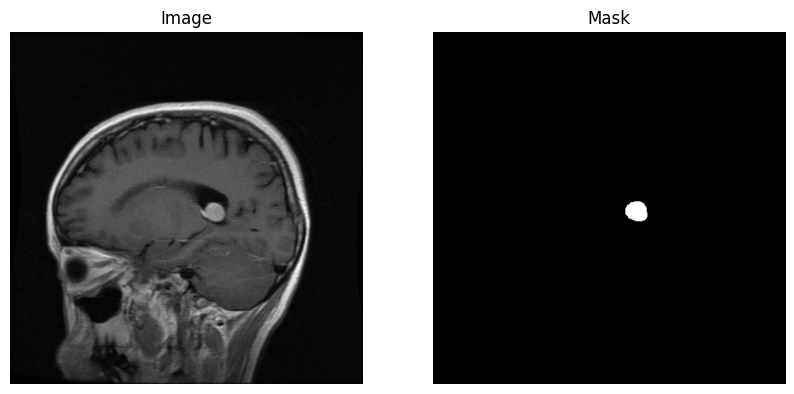

In [5]:
import matplotlib.pyplot as plt
def display_sample(data, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data['images'][index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data['masks'][index], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display a sample to verify
display_sample({'images': images, 'masks': masks}, index=0)

In [6]:
from skimage.transform import resize
def preprocess_images(images, masks, target_shape=(256, 256)):
    processed_images = np.array([resize(img, target_shape, preserve_range=True) for img in images])
    processed_masks = np.array([resize(mask, target_shape, mode='constant', anti_aliasing=False) for mask in masks])

    # Normalize images
    processed_images = processed_images.astype('float32') / 255.0

    return processed_images, processed_masks

images_processed, masks_processed = preprocess_images(images, masks)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_processed, masks_processed, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def unet_plusplus_model(input_size=(256, 256, 1)):
    # Define input layer
    inputs = Input(input_size)

    # First Convolution Block
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Second Convolution Block
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Third Convolution Block
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Fourth Convolution Block
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Fifth Convolution Block (Bottleneck)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Fourth Up-Sampling Block
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    up4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up4)
    up4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up4)

    # Third Up-Sampling Block
    up3 = concatenate([UpSampling2D(size=(2, 2))(up4), conv3], axis=-1)
    up3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    up3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)

    # Second Up-Sampling Block
    up2 = concatenate([UpSampling2D(size=(2, 2))(up3), conv2], axis=-1)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)

    # First Up-Sampling Block
    up1 = concatenate([UpSampling2D(size=(2, 2))(up2), conv1], axis=-1)
    up1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net++ model
model = unet_plusplus_model()

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 256, 256, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_13[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_14[0][0]']           
 g2D)                                                                                       

In [15]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)



Epoch 1/20
307/307 [==============================] - 203s 548ms/step - loss: 0.2622 - accuracy: 0.9801 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 2/20
287/307 [===========================>..] - ETA: 8s - loss: 0.2611 - accuracy: 0.9831

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
predictions = model.predict(X_val)

In [ ]:
def display_comparison(indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
display_comparison([0, 1, 2])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
colors = ['black', 'red', 'green']  # Add more colors if there are more classes
cmap = ListedColormap(colors)

def display_comparison(predictions, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap=cmap)
        plt.title(f'Predicted Mask for Image {idx}')
        plt.axis('off')
    plt.show()
display_comparison(predictions, [0, 1, 2])


In [ ]:
predicted_masks = model.predict(X_val)

In [ ]:
def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Display a sample of predicted masks on original images
display_predicted_masks(X_val, y_val, predicted_masks, index=0)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red'])

def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap=cmap)
    plt.title('Predicted Mask (Highlighted)')
    plt.axis('off')

    plt.show()
display_predicted_masks(X_val, y_val, predicted_masks, index=150)
